# Mistral Large 2 JSON Mode Dive Deep

Mistral Large 2 now offers a native JSON output mode. This feature allows developers to receive the model's responses in a structured, easy-to-read format that can be readily integrated into various applications and systems. With JSON being a widely adopted data exchange standard, this capability simplifies the process of working with the model's outputs, making it more accessible and practical for developers across different domains and use cases. 


The model is currently generally available for use on Amazon Bedrock, check out the [blog post](https://aws.amazon.com/blogs/machine-learning/mistral-large-2-is-now-available-in-amazon-bedrock/) for more info.

In this notebook, we will be demonstrating JSON Output capabilities for two specific use cases:

1. Entity Extraction Phase from Raw Text for Building Knowledge Graphs for Graph-based Retrieval-Augmented Generation (RAG)
- Because it represents a trending pattern in retrieval augmented generation, where structured knowledge graphs enhance contextual understanding. 
- Automating the graph modeling process from raw text is essential yet often complex, and Mistral Large 2's native JSON output simplifies this by efficiently structuring extracted entities and relationships.

2.  Integration with APIs or Other Web-based Services
- Because It is a common approach for converting human text into structured queries. 
- This use case highlights how native JSON output reduces the need for intermediary data processing steps, streamlining the connection between natural language interfaces and APIs. 
- Additionally, using JSON enhances maintainability, making it easier to adapt to changes in API specifications.


#### Import necessary libraries

In [2]:
import boto3
import networkx as nx 

session = boto3.Session(region_name="us-west-2")
bedrock_client = session.client(service_name='bedrock-runtime')

#### Create Bedrock Client

In [3]:
bedrock_client = boto3.client(service_name='bedrock-runtime', region_name="us-west-2")

#### Instantiate model ids of mistral model being used

In [4]:
mistral_large_2 = 'mistral.mistral-large-2407-v1:0'

model_id = mistral_large_2

---
## Entity Extraction Phase from Raw Text

Entity extraction is the process of identifying and extracting relevant entities (e.g., people, organizations, locations, dates, etc.) from raw text input. This capability is crucial in various natural language processing (NLP) tasks and applications, such as information retrieval, knowledge graph construction, and question answering systems.

By leveraging Mistral Large 2's JSON output mode, developers can receive the extracted entities in a structured JSON format, making it easier to process and integrate them into downstream applications or pipelines.

One notable example where entity extraction plays a vital role is in Graph-based Retrieval-Augmented Generation (RAG). In this technique, the extracted entities serve as the initial seed for querying external knowledge sources, such as knowledge graphs or databases, to retrieve additional information and augment the language model's knowledge. The structured JSON output from the entity extraction phase can be seamlessly ingested into the RAG pipeline, facilitating the construction or updating of knowledge graphs from raw text input.

To generate JSON with the Converse API, you need to define a toolSpec. In the following code, we define a schema for the entity extraction. 

In [5]:
# Define the tool configuration
import json
tool_list = [
    {
        "toolSpec": {#‰
            "name": "entity_extractor",
            "description": "Converts text into an entity json structure.",
            "inputSchema": {
                "json": {
                    "type": "object",
                    "properties": {
                        "entity": {
                            "type": "array",
                            "items": {
                                "type": "object",
                                "properties": {
                                    "entity_name": {
                                        "type": "string",
                                        "description": "The entity name."
                                    },
                                    "entity_description": {
                                        "type": "string",
                                        "description": "The description of the entity"
                                    },
                                    "entity_type": {
                                        "type": "string",
                                        "description": "The entity type.",
                                        "enum": ["People", "Organization", "Event", "Location", "Technology/Product"]
                                    }
                                }
                            }
                        }
                    },
                    "required": [
                        "entity"
                    ]
                }
            }
        }
    }
]


Extract entities from 500-word text about the history of the Internet and the World Wide Web:

In [6]:

content = """
The history of the Internet and the World Wide Web:

The Internet and the World Wide Web have revolutionized the way we communicate, access information, and conduct business. The origins of the Internet can be traced back to the 1960s when the Advanced Research Projects Agency (ARPA), a branch of the United States Department of Defense, initiated a research program to develop a decentralized communication network capable of withstanding potential nuclear attacks.

This research led to the creation of ARPANET, the precursor to the modern Internet. Initially, ARPANET connected a few universities and research centers, allowing researchers to share data and resources. Over time, more institutions joined the network, and the concept of interconnecting networks emerged, laying the foundation for the Internet as we know it today.

In the 1970s and 1980s, the Internet continued to evolve, with the development of key technologies such as the Transmission Control Protocol/Internet Protocol (TCP/IP), which standardized the way data is transmitted over the network. During this period, the Internet remained primarily a tool for researchers and academics.

The true revolution came in 1989 when Tim Berners-Lee, a computer scientist at CERN (the European Organization for Nuclear Research), proposed the idea of the World Wide Web. Berners-Lee envisioned a system that would allow researchers to easily share and access information across the Internet. He developed the first web browser, server, and the Hypertext Transfer Protocol (HTTP), which enabled the retrieval and display of hypertext documents on the Internet.

The World Wide Web quickly gained popularity, and in 1993, Marc Andreessen and his team at the National Center for Supercomputing Applications (NCSA) released Mosaic, the first widely-used graphical web browser. This user-friendly interface made the Web accessible to a broader audience, sparking a surge in Internet adoption and usage.

As the Internet and the Web grew, various companies and organizations emerged to provide services and infrastructure. Internet Service Providers (ISPs) facilitated access to the Internet for individuals and businesses, while web hosting companies offered platforms for hosting websites and web applications.

The rise of e-commerce in the late 1990s further accelerated the growth of the Internet and the Web. Companies like Amazon, eBay, and others pioneered online shopping and digital marketplaces, transforming the way we buy and sell goods and services.

Today, the Internet and the World Wide Web have become integral parts of our daily lives. Social media platforms like Facebook, Twitter, and Instagram have revolutionized how we connect and share information. Online streaming services like Netflix and YouTube have disrupted traditional media and entertainment industries. Cloud computing and software-as-a-service (SaaS) models have transformed the way businesses operate and deliver services.

Despite the immense progress and innovation, the Internet and the Web continue to evolve, driven by emerging technologies such as the Internet of Things (IoT), artificial intelligence, and blockchain. As we look to the future, these technologies promise to further revolutionize the way we live, work, and interact with the digital world.
"""

message = {
    "role": "user",
    "content": [
        { "text": f"<content>{content}</content>" },
        { "text": "Please create a well-structured JSON object extracting the entities of the text. Create the JSON based on the content within the <content> tags." }
    ],
}

In [7]:


# Bedrock client configuration
response = bedrock_client.converse(
    modelId=model_id,
    messages=[message],
    inferenceConfig={
        "maxTokens": 4000,
        "temperature": 0.2
    },
    toolConfig={
        "tools": tool_list
    }
)

response_message = response['output']['message']
response_content_blocks = response_message['content']
content_block = next((block for block in response_content_blocks if 'toolUse' in block), None)
tool_use_block = content_block['toolUse']
tool_result_dict = tool_use_block['input']
entity_list= tool_result_dict
print(json.dumps(entity_list, indent=4))

{
    "entity": [
        {
            "entity_name": "Advanced Research Projects Agency",
            "entity_description": "A branch of the United States Department of Defense.",
            "entity_type": "Organization"
        },
        {
            "entity_name": "ARPANET",
            "entity_description": "The precursor to the modern Internet.",
            "entity_type": "Technology/Product"
        },
        {
            "entity_name": "Tim Berners-Lee",
            "entity_description": "A computer scientist at CERN who proposed the idea of the World Wide Web.",
            "entity_type": "People"
        },
        {
            "entity_name": "CERN",
            "entity_description": "The European Organization for Nuclear Research.",
            "entity_type": "Organization"
        },
        {
            "entity_name": "World Wide Web",
            "entity_description": "A system that allows researchers to easily share and access information across the Internet.",
 

#### Entity schema
To maintain consistency in extracting relationships between entities across chunks, we create a list of node names extracted in the previous invocation. Those start forming the extracted schema and serve as input parameters of the next toolspec

In [8]:
#extract entity name and type from the tool_result_dict variable
schema = []
for entity in tool_result_dict['entity']:
    schema.append(entity['entity_name'])

In [9]:
schema

['Advanced Research Projects Agency',
 'ARPANET',
 'Tim Berners-Lee',
 'CERN',
 'World Wide Web',
 'Marc Andreessen',
 'Mosaic',
 'National Center for Supercomputing Applications',
 'Internet Service Providers',
 'Amazon',
 'eBay',
 'Facebook',
 'Twitter',
 'Instagram',
 'Netflix',
 'YouTube',
 'Internet of Things',
 'artificial intelligence',
 'blockchain']

Now for each node, let's extract relationship.
The following toolspec request the output to be a list of relionship between entities. Entities will be then ingested as edge in our graph database.

In [16]:
# Define the tool configuration
import json
tool_list = [
    {
        "toolSpec": {#‰
            "name": "relationship_extractor",
            "description": "Converts text into an relationship json structure.",
            "inputSchema": {
                "json": {
                    "type": "object",
                    "properties": {
                        "relationship": {
                            "type": "array",
                            "items": {
                                "type": "object",
                                "properties": {
                                    "entity_1": {
                                        "type": "string",
                                        "description": "The name of the first entity.",
                                        "enum": schema
                                    },
                                    "entity_2": {
                                        "type": "string",
                                        "description": "The name of the second entity",
                                        "enum": schema
                                    },
                                    "relationship": {
                                        "type": "string",
                                        "description": "The relationship entity 1 has with entity 2."
                                    }
                                }
                            }
                        }
                    },
                    "required": [
                        "entity_1",
                        "entity_2",
                        "relrelationshipa"
                    ]
                }
            }
        }
    }
]


In [17]:
message = {
    "role": "user",
    "content": [
        { "text": f"<content>{content}</content>" },
        { "text": f"<entities>{schema}</entitoes>" },
        { "text": "Please create a well-structured JSON object extracting the relationship of each entity in the tag <entities>.  Extract only clear and existing relationships from the text in the <content> tag. " }
    ],
}

In [18]:


# Bedrock client configuration
response = bedrock_client.converse(
    modelId=model_id,
    messages=[message],
    inferenceConfig={
        "maxTokens": 4000,
        "temperature": 0.1
    },
    toolConfig={
        "tools": tool_list
    }
)

response_message = response['output']['message']
response_content_blocks = response_message['content']
content_block = next((block for block in response_content_blocks if 'toolUse' in block), None)
tool_use_block = content_block['toolUse']
tool_result_dict = tool_use_block['input']
print(json.dumps(tool_result_dict, indent=4))

{
    "relationship": [
        {
            "relationship": "created",
            "entity_1": "Advanced Research Projects Agency",
            "entity_2": "ARPANET"
        },
        {
            "relationship": "proposed",
            "entity_1": "Tim Berners-Lee",
            "entity_2": "World Wide Web"
        },
        {
            "relationship": "developed",
            "entity_1": "Tim Berners-Lee",
            "entity_2": "World Wide Web"
        },
        {
            "relationship": "released",
            "entity_1": "Marc Andreessen",
            "entity_2": "Mosaic"
        },
        {
            "relationship": "facilitated",
            "entity_1": "Internet Service Providers",
            "entity_2": "Internet"
        },
        {
            "relationship": "pioneered",
            "entity_1": "Amazon",
            "entity_2": "e-commerce"
        },
        {
            "relationship": "pioneered",
            "entity_1": "eBay",
            "entity_2": 

Visualize the entity and reltionship extracted from the Model

In [19]:
G = nx.Graph()
G.add_nodes_from(schema)

for relationship in tool_result_dict['relationship']:
    #check entity_1 and entity_2 exist in relationship
    if 'entity_1' in relationship and 'entity_2' in relationship:
        G.add_edge(relationship["entity_1"], relationship["entity_2"])


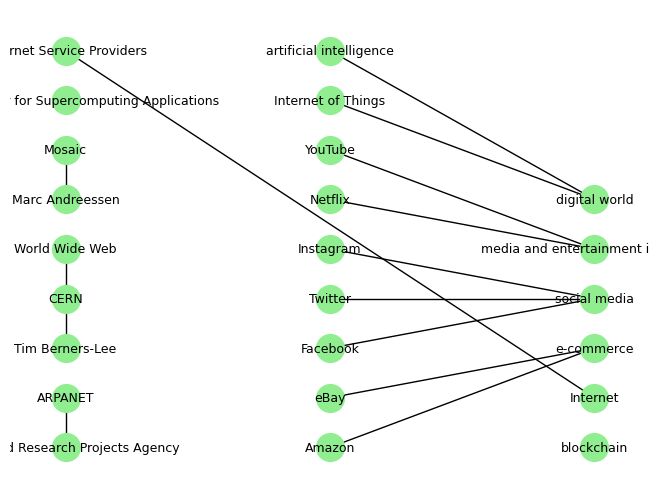

In [20]:
pos = dict(zip(list(G.nodes()), nx.grid_2d_graph(3 * 3, 3 * 3)))
nx.draw(G, pos = pos, ax = None, with_labels = True,font_size = 9, width=1, node_size = 400, node_color = 'lightgreen')

---
## Integration with APIs and Web-Based Services

In this use case, we'll explore how Mistral Large 2's JSON output mode can be leveraged to seamlessly integrate with external APIs and web-based services, focusing on a property management system. This capability is crucial for automating workflows, enhancing data processing, and creating more intelligent and responsive systems.

We'll demonstrate this integration using two practical scenarios:
1. Adding new properties to a database
2. Searching for properties based on specific criteria

What makes this example particularly interesting is that we'll provide the model with two different JSON schemas:
1. A schema for adding a new property (addProperty)
2. A schema for listing properties based on search criteria (listProperties)

We'll let Mistral Large 2 decide which schema to use based on the content of the input text. This showcases the model's ability to not only structure data but also to choose the appropriate format based on the context of the request.


The `addProperty` schema allows for the creation of new property listings with details such as type (House or Flat), description, location, size, number of bedrooms, and price. The `listProperties` schema enables searching for properties with filters like property type, location, minimum size, minimum number of bedrooms, and maximum price.


Through this example, we'll see how Mistral Large 2's JSON output capabilities can enhance the efficiency and accuracy of API integrations.

#### Setup and Configuration
First, let's set up our environment and define the JSON schemas for our property management tools.

In [21]:
# Define the tool configuration
import json
tool_list = [
    {
        "toolSpec": {
            "name": "addProperty",
            "description": "Creates a new property in the store.",
            "inputSchema": {
                "json": {
                    "type": "object",
                    "properties": {
                        "type": {
                            "type": "string",
                            "description": "Property type",
                            "enum": ["House", "Flat"]
                        },
                        "description": {
                            "type": "string",
                            "description": "Description of the property"
                        },
                        "location": {
                            "type": "string",
                            "description": "Location of the property"
                        }, 
                        "size": {
                            "type": "integer",
                            "description": "square meter of the property"
                        },
                         "bedrooms": {
                            "type": "integer",
                            "description": "number of bedroms"
                        },
                         "price": {
                            "type": "integer",
                            "description": "price of the property"
                        }
                    },
                    "required": [
                        "type",
                        "location",
                        "size",
                        "price"
                    ]
                }
            }
        }
    },
    {
         "toolSpec": {
            "name": "listProperties",
            "description": "Search all properties corresponding to the desired filters",
            "inputSchema": {
                "json": {
                    "type": "object",
                    "properties": {
                        "type": {
                            "type": "string",
                            "description": "Property type",
                            "enum": ["House", "Flat"]
                        },
                        "location": {
                            "type": "string",
                            "description": "Location of the property"
                        }, 
                        "size": {
                            "type": "integer",
                            "description": "square meter of the property"
                        },
                         "minbedrooms": {
                            "type": "integer",
                            "description": "minimum number of bedrooms"
                        },
                         "maxprice": {
                            "type": "integer",
                            "description": "maximum price of the property"
                        }
                    },
                    "required": [
                        "type",
                        "location"
                    ]
                }
            }
        }
    }
]


#### Example 1: Adding a New Property
In this example, we'll demonstrate how to use Mistral Large 2 to process a natural language request to add a new property and generate the appropriate JSON output.

In [22]:
content = """
Add a new house in Paris with 3 bedrooms, 120 square meters, priced at 500000 euros. It has a beautiful view of the Eiffel Tower.
"""

message = {
    "role": "user",
    "content": [
        { "text": f"<content>{content}</content>" },
        { "text": "Please create a well-structured JSON object, ensuring proper nesting and organization of the data. Create the JSON based on the content within the <content> tags." }
    ],
}

In [23]:
# Bedrock client configuration
response = bedrock_client.converse(
    modelId=model_id,
    messages=[message],
    inferenceConfig={
        "maxTokens": 500,
        "temperature": 0.1
    },
    toolConfig={
        "tools": tool_list
    }
)

response_message = response['output']['message']
response_content_blocks = response_message['content']
content_block = next((block for block in response_content_blocks if 'toolUse' in block), None)
tool_use_block = content_block['toolUse']
tool_result_dict = tool_use_block['input']

print("tool used: "+tool_use_block["name"])
print(json.dumps(tool_result_dict, indent=4))

tool used: addProperty
{
    "bedrooms": 3,
    "description": "It has a beautiful view of the Eiffel Tower.",
    "location": "Paris",
    "type": "House",
    "size": 120,
    "price": 500000
}


#### Example 2: Searching for Properties
Now, let's show how to use Mistral Large 2 to process a natural language query for property search and generate the appropriate JSON output.


In [24]:

content = """
Find me apartments in London with at least 2 bedrooms and a maximum price of 400000 pounds.
"""

message = {
    "role": "user",
    "content": [
        { "text": f"<content>{content}</content>" },
        { "text": "Please create a well-structured JSON object, ensuring proper nesting and organization of the data. Create the JSON based on the content within the <content> tags." }
    ],
}

In [25]:
# Bedrock client configuration
response = bedrock_client.converse(
    modelId=model_id,
    messages=[message],
    inferenceConfig={
        "maxTokens": 500,
        "temperature": 0.1
    },
    toolConfig={
        "tools": tool_list
    }
)

response_message = response['output']['message']
response_content_blocks = response_message['content']
content_block = next((block for block in response_content_blocks if 'toolUse' in block), None)
tool_use_block = content_block['toolUse']
tool_result_dict = tool_use_block['input']

print("tool used: "+tool_use_block["name"])
print(json.dumps(tool_result_dict, indent=4))

tool used: listProperties
{
    "location": "London",
    "type": "Flat",
    "minbedrooms": 2,
    "maxprice": 400000
}
